THE RISK-ESTIMATION BIAS-VARIANCE TRADEOFF

author: [@sparshsah](https://github.com/sparshsah)

# Setting

Suppose you have a series of observations $(r_1,\, r_2,\, \dots,\, r_{T})$ where each observation is i.i.d. Normal with ground-truth mean $\mu$ and ground-truth variance $\sigma^2$.

# Estimators

Consider three estimators for $\sigma^2$. We're implicitly going to consider Mean Squared Error (MSE) as our loss function when evaluating them, but MSE isn't necessarily the best one. Which loss function is most appropriate can depend on the setting and application. For example, maybe in your particular use case, underestimating $\sigma^2$ is more dangerous than overestimating.


## Standard Bessel-corrected demeaned sample variance estimator

Define
$$s^2_A := \frac{1}{T-1} \sum(r_t - \bar{r})^2.$$

This will be distributed as
$$\frac{1}{T-1}\sigma^2\chi^2_{T-1}.$$

Its bias is $0$, so its squared bias is also $0$.

Its squared standard error is $\frac{1}{(T-1)^2}\sigma^4 2(T-1) = 2\frac{1}{T-1}\sigma^4$.

The sum of its squared bias plus squared standard error is
$$2\frac{1}{T-1}\sigma^4.$$

This has one undesirable property in the case I mentioned before: If underestimating $\sigma^2$ is more dangerous than overestimating. This estimator will grossly underestimate, for instance, if all the $r$'s just randomly happen to come out to the same number.


## Overriden zero-meaned sample variance estimator

Define
$$s^2_B := \frac{1}{T} \sum r_t^2.$$

This will be distributed as
$$\mu^2 + \frac{1}{T}\sigma^2\chi^2_{T}.$$

Its bias is $\mu^2$, so its squared bias is $\mu^4$.

Its squared standard error is $\frac{1}{T^2}\sigma^4 2T = 2\frac{1}{T}\sigma^4$.

The sum of its squared bias plus squared standard error is
$$\mu^4 + 2\frac{1}{T}\sigma^4.$$


## Minimum-MSE sample variance estimator

Define
$$s^2_C := \frac{1}{T+1} \sum(r_t - \bar{r})^2.$$

This is the best you can do in terms of MSE [[cf](https://web.archive.org/web/20210522072302/https://en.wikipedia.org/wiki/Mean_squared_error#Variance)], but I'm not sure what its distribution is.

# MSE-dominance crossover Sharpe

Let's compare $s^2_B$ vs $s^2_A$. When will the overriden estimator's sum of squared bias plus squared standard error be better (i.e. smaller) than the standard's?

Well, when
$$\mu^4 + 2\frac{1}{T}\sigma^4 < 2\frac{1}{T-1}\sigma^4$$
$$\mu^4 < 2\left(\frac{1}{T-1} - \frac{1}{T}\right)\sigma^4$$
$$\mu^4 < 2\frac{1}{(T-1)T}\sigma^4$$
$$\mu < \sqrt[4]{2\frac{1}{(T-1)T}}\sigma$$
$$\frac{\mu}{\sigma} < \sqrt[4]{2\frac{1}{(T-1)T}}.$$

We'll call this threshold the "crossover Sharpe".

## Upshot

For example, if $T = 65$ days, then $s^2_B$ will have a lower sum-of-squared-bias-plus-squared-standard-error (i.e. lower MSE) than $s^2_A$ as long as the ratio of $\mu$ to $\sigma$ (each for a single observation, i.e. a single day) is less than $\approx 0.148$ (i.e. a daily Sharpe less than $\approx 0.148$). In other words: With a single business quarter of daily-returns data, the zero-meaned estimator would be better (from an MSE perspective) than the demeaned estimator as long as the asset's ground-truth business-annualized Sharpe was less than $\approx 261^{0.5} \cdot 0.148 = 2.39$. A business quarter is a reasonable and popular estimation horizon (to deal with the fact that market data-generating processes are highly non-stationary), and most assets' ground-truth annualized Sharpes are much less than $2.39$, so this is a pretty common scenario.

_On the other hand_: Even if you had a full business century ($T = 100 \cdot 261 = 26,100$ days) of daily-returns data, the zero-meaned estimator would _still_ be better as long as the asset's ground-truth daily Sharpe was less than $\approx 0.0074$, which annualizes to $\approx 261^{0.5} \cdot 0.0074 \approx 0.12$ -- A surprisingly high figure in my eyes. Put another way: There are commodities out there whose ground-truth annualized Sharpes are widely assumed to be around $0.10$. This result says that even if you had high-quality daily returns data going back to 1922, you should _still_ use the zero-meaned variance estimator if you want to get lower expected squared estimation error.


## An interesting observation: Annualized crossover Sharpe is asymptotically frequency-independent

I'm going to do two blind-plug-and-chug exercises here, which will induce a generalized observation. (The proof of this observation will be left to the reader, because it's easy to see---just divide your sample size $T$ by your chosen annualizer $D$ in the formula---but annoying to type out.)

# Simulations

In [1]:
import pandas as pd
import numpy as np
# https://github.com/sparshsah/foggy-lib/blob/main/util/foggy_pylib/core.py
import foggy_pylib.core as fc
# https://github.com/sparshsah/foggy-lib/blob/main/util/foggy_pylib/fin.py
import foggy_pylib.fin as ff

## How does the annualized crossover Sharpe decay with sample size?

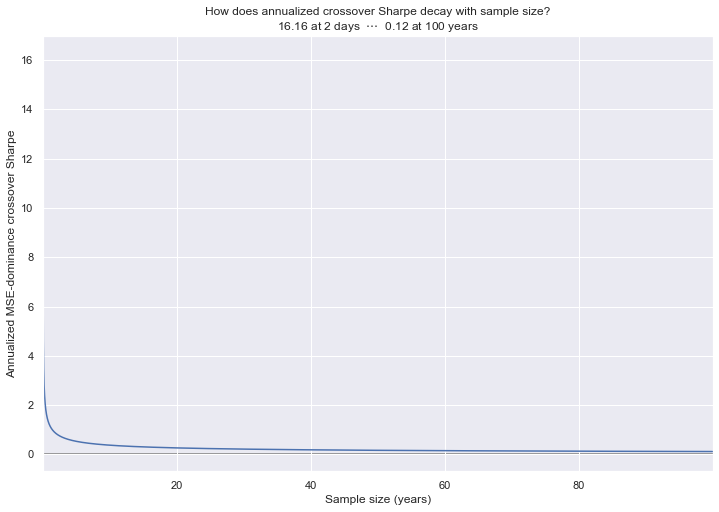

In [21]:
MIN_T_DAYS = 2  # need at least 2 data points for the standard estimator to be defined
MAX_T_DAYS = ff.DAYCOUNTS["BY"] * 100  # a century

def __get_daily_crossover_sharpe(T_days: int=ff.DAYCOUNTS["BQ"]) -> float:
    numerator = 2
    denominator = (T_days-1) * T_days
    fraction = numerator / denominator
    answer = fraction **(1/4)
    return answer

def _get_ann_crossover_sharpe(T_days: int=ff.DAYCOUNTS["BQ"]) -> float:
    daily_crossover_sharpe = __get_daily_crossover_sharpe(T_days=T_days)
    ann_crossover_sharpe = ff.DAYCOUNTS["BY"]**0.5 * daily_crossover_sharpe
    return ann_crossover_sharpe

def get_ann_crossover_sharpes() -> ff.FloatSeries:
    ann_crossover_sharpes = pd.Series({T_days:
        _get_ann_crossover_sharpe(T_days=T_days)
    for T_days in range(MIN_T_DAYS, MAX_T_DAYS)})
    return ann_crossover_sharpes

def plot_ann_crossover_sharpes() -> None:
    s = get_ann_crossover_sharpes()
    # convert from T_days to T_years
    s.index = s.index/ff.DAYCOUNTS["BY"]
    fc.plot(
        s,
        xlabel="Sample size (years)",
        ylabel="Annualized MSE-dominance crossover Sharpe",
        title="How does annualized crossover Sharpe decay with sample size?\n" + \
            f"{s.values[0]:.2f} at {int(s.index[0] * ff.DAYCOUNTS['BY'])} days" + \
            r"  $\cdots$  " + \
            f"{s.values[-1]:.2f} at {s.index[-1]:.0f} years"
    )

plot_ann_crossover_sharpes()

## Does it really make a difference?

NO up to like the 99.9th percentile lmao what an anticlimactic result

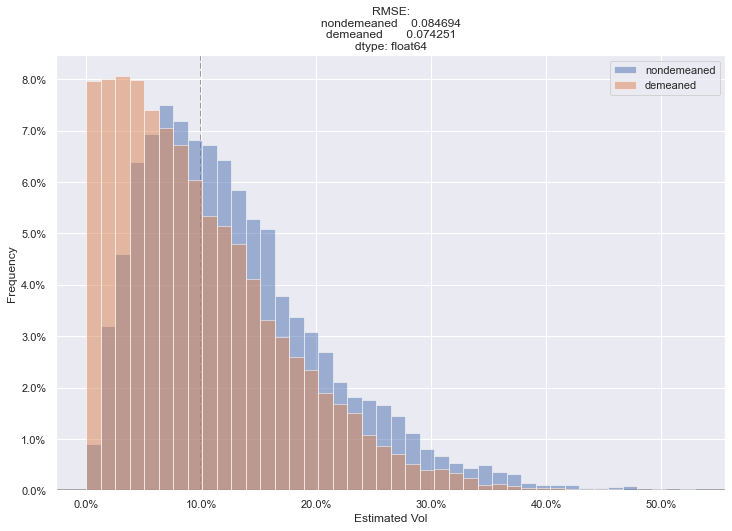

In [12]:
# let's choose a low sharpe (0) with a small sample size (2 days), and see whether this really helps us
LOW_SHARPE = 0
SMALL_N_YEARS = 2/261
NSIMS = 1_00

def _sim() -> ff.FloatSeries:
    r = ff._sim_r(ann_sharpe=LOW_SHARPE, n_years=SMALL_N_YEARS)
    est_vol = fc.get_series([
        ("nondemeaned", ff._get_est_vol_of_r(r=r)),
        ("demeaned", ff._get_est_vol_of_r(r=r, de_avg_kind="mean"))
    ])
    return est_vol

def sim() -> ff.FloatDF:
    est_vol = pd.DataFrame([_sim() for _ in range(NSIMS)])
    return est_vol

def plot_sim() -> None:
    np.random.seed(42)
    est_vol = sim()
    rmse = ((est_vol - ff.DEFAULT_VOL)**2).mean()**0.5
    fc.plot(
        est_vol, kind="histpct",
        bins=42, alpha=0.50,
        axvline_locs=[ff.DEFAULT_VOL],
        axvline_styles=["--"],
        xpct=True,
        xlabel="Estimated Vol",
        ylabel="Frequency",
        title=f"RMSE:\n{rmse}"
    )

plot_sim()

## How punitive is the overriden Sharpe estimator on a century of live data?

From our playing-around above, it barely makes a dent in the problem up to like the 99th percentile, so I'd be fine just killing the override-mean default in my library. But from our playing-around below, it really doesn't appreciably underestimate across the domain of reasonable Sharpes (between $-3$ and $+3$ annualized), so I'd also feel OK leaving the override-mean (which I like intuitively) as the default behavior in my library... I'll have to think about this.

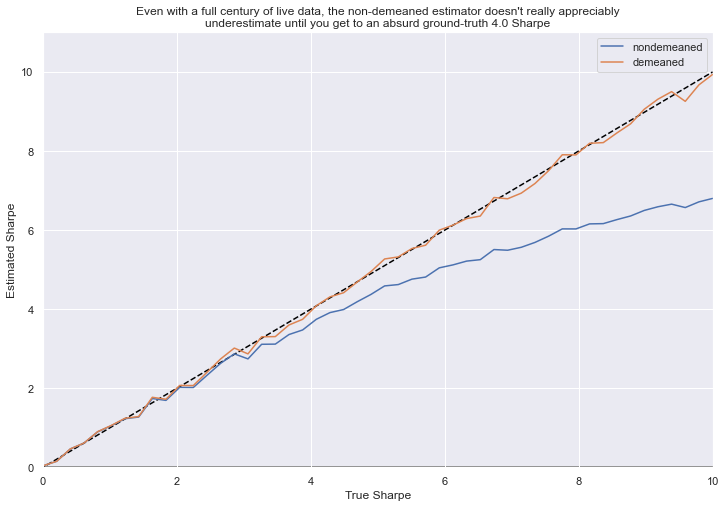

In [8]:
def _sim(true_sharpe: float=0) -> ff.FloatSeries:
    r = ff._sim_r(ann_sharpe=true_sharpe)
    est_sharpe = fc.get_series([
        ("nondemeaned", ff._get_est_sharpe_of_r(r=r)),
        ("demeaned", ff._get_est_sharpe_of_r(r=r, de_avg_kind="mean"))
    ])
    return est_sharpe

def sim() -> ff.FloatDF:
    est_sharpe = pd.DataFrame({true_sharpe: _sim(true_sharpe=true_sharpe) for true_sharpe in np.linspace(0,10)}).T
    return est_sharpe

def plot_sim() -> None:
    np.random.seed(42)
    est_sharpe = sim()
    ax = fc.get_y_equals_x_plot_base(lim=10)
    fc.plot(
        est_sharpe,
        xlabel="True Sharpe",
        ylabel="Estimated Sharpe",
        title="Even with a full century of live data, the non-demeaned estimator doesn't really appreciably\n" + \
            "underestimate until you get to an absurd ground-truth 4.0 Sharpe",
        ax=ax,
        # override from the ax
        ylim_bottom=0
    )

plot_sim()